# 计算机网络体系结构第一次作业

## 实验设置

买卖的最小单位是一手，即 100 份。

### 买入

若忽略起点，买入费率为 0.038%

- 考虑买入证券交易费：过户费、佣金
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = deltaPosition * stockToday["收盘"]
costBuy = deltaPositionValue*0.02/1e3 + max(deltaPositionValue*0.018/100, 5)
#self.cash -= deltaPosition * stockToday["收盘"]
self.cash = self.cash - deltaPositionValue - costBuy

#没有考虑self.cash不够，出现负数的情况
```

### 卖出

若忽略起点，买入费率为 0.043%

- 考虑买入证券交易费：印花税、过户费、佣金
- 印花税：单向收取，卖出成交金额的万分之五（5‱）印花税由政府收取
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = pos["头寸"] * stockToday["收盘"]
costSell = deltaPositionValue*(1e-3 + 0.02/1e3) + max(deltaPositionValue*0.018/100, 5)
```


## 实验代码及说明


### 准备依赖


In [81]:
# !python -m pip install akshare matplotlib numpy pandas

In [82]:
import akshare as ak
import calendar
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl
import os

mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False

### 准备实验数据


In [83]:
stockNameCodes: list[tuple[str, str]] = [
    ("512200", "房地产ETF"),
    ("513050", "中概互联网ETF"),
    ("510300", "沪深300ETF"),
    ("510050", "上证50ETF"),
    ("510500", "中证500ETF"),
    ("159915", "创业板ETF"),
    ("159902", "中小100ETF"),
    ("512010", "医药ETF"),
    ("512880", "证券ETF"),
    ("512580", "环保ETF"),
    ("159920", "恒生ETF"),
    ("510900", "H股ETF"),
    ("513500", "标普500ETF"),
    ("513100", "纳指ETF"),
    ("512660", "军工ETF")
]


def Preprocess(startDate: datetime.datetime, endDate: datetime.datetime):
    # 获取标的历史数据
    startDate = startDate - datetime.timedelta(days=365)

    allStockDaily: dict[str, pd.DataFrame] = {}
    path = f'data/{startDate.strftime("%Y")}-{endDate.strftime("%Y")}'
    if os.path.exists(path):
        print(f'使用已有数据({startDate.strftime("%Y")}-{endDate.strftime("%Y")})')
        for code, name in stockNameCodes:
            stockDaily = pd.read_csv(os.path.join(
                path, f"{name}_{code}.csv"), sep=',')
            stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])
            stockDaily = stockDaily.set_index("日期", drop=False)

            allStockDaily[code] = stockDaily
        return allStockDaily

    os.makedirs(path)
    for i, (code, name) in enumerate(stockNameCodes):
        print(f"{i}. {name}({code}) 正在读取数据...")
        try:
            # stockDaily = ak.stock_zh_a_hist(
            stockDaily = ak.fund_etf_hist_em(
                symbol=code,
                period="daily",
                start_date=startDate.strftime("%Y%m%d"),
                end_date=endDate.strftime("%Y%m%d"),
                adjust="hfq",
            )
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}读取失败!'
            )
            continue
        # print(stockDaily.columns)
        stockDaily = stockDaily[stockDaily["开盘"].notnull()]
        stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])

        stockDaily.to_csv(os.path.join(
            path, f"{name}_{code}.csv"), index=False)
        stockDaily = stockDaily.set_index("日期", drop=False)

        allStockDaily[code] = stockDaily
    return allStockDaily


start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2024, 3, 14)
allStockDaily = Preprocess(start, end)
print(f"共有{len(allStockDaily)}个标的数据")

使用已有数据(2016-2024)
共有15个标的数据


### 实验内容

#### 单个 ETH 上的测试

In [84]:
def calc(stockNameCode: tuple[str, str]):
    df = allStockDaily[stockNameCode[0]]
    # print(df.iloc[:, 0])
    # 设置显示中文字体

    print(f"开始计算{stockNameCode[1]}")
    ax = plt.axes(title=stockNameCode[1])
    normalized = df.iloc[:, 1]/df.iloc[0, 1]
    # 不太能理解的是这个地方为什么不能正常显示标签。
    normalized.plot(ax=ax, x='日期', y='开盘', label='当日开盘价与首日开盘价的比值')
    step = datetime.timedelta(days=90)

    periods_total: int = (df.iloc[-1, 0] - df.iloc[0, 0])//step+1
    periods = periods_total
    cur: pd.DatetimeIndex = df.iloc[0, 0]
    # 初始资金：一百万
    INIT = 1000000
    money = INIT
    # 股票数量
    stocks = 0
    # 额外费用：过户费、佣金、印花税
    global total_extra
    total_extra = 0

    SILENT = False

    def buy(num: float, store: bool = True):
        global total_extra
        brokerage = round(num * 18 / 1e5, 2)
        if not SILENT and brokerage < 5:
            print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
        extra = round(round(num / 5000, 2) + max(5, brokerage), 2)
        if store:
            total_extra += extra
        return round(num + extra, 2)

    def sell(num: float, store: bool = True):
        assert num > 0
        global total_extra
        brokerage = round(num * 18 / 1e5, 2)
        if not SILENT and brokerage < 5:
            print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
        extra = round(round(num / 4000, 2) + max(5, brokerage), 2)
        if store:
            total_extra += extra
        return round(num - extra, 2)

    l = []

    i = 1
    for date, row in df.iterrows():
        date: pd.DatetimeIndex
        price: float = row[1]
        asset_now = ((money+sell(stocks*price, store=False))
                     if stocks > 0 else money)/INIT
        l.append(pd.DataFrame(
            [{'日期': date, '资产': asset_now}]))
        if cur <= date:
            # 本期准备使用的资金金额
            period_money = money/periods

            # 本期准备购买的股票数量
            stock_count = period_money//price//100

            # 本期准备购买的股票总价
            stock_price = stock_count*100*price
            while money < buy(stock_price, False):
                stock_count -= 1
                stock_price = stock_count*100*price
                assert stock_count >= 0, f"剩余资金 {money} 不足以购买一手股票"
            money -= buy(stock_price)
            # assert money >= 0
            money = round(money, 2)
            stocks += stock_count*100
            if not SILENT:
                STOCK_PRICE = sell(stocks*price, store=False)
                print(
                    f"第 {i} / {periods_total} 期（{date}）: {money} + {STOCK_PRICE} = {money+STOCK_PRICE}")
            cur += step
            i += 1
            periods -= 1

    # 资产比值
    asset = pd.DataFrame(columns=['日期', '资产'])
    asset = pd.concat([asset, *l])
    asset.set_index('日期', drop=False, inplace=True)
    asset.plot(ax=ax, x='日期', y='资产', label='当日资产与初始资产的比值')
    price: float = df.iloc[-1, 1]
    ratio: float = price/df.iloc[0, 1]
    print(f"Money: {money}")
    print(f"Stock: {stocks}")
    print(f"Price: {price}")
    print(f"Price Ratio: {ratio}")
    final = round(sell(stocks*price), 2)
    print(f"Stock Name: {stockNameCode[1]}")
    print(f"Total Extra Cost: {total_extra}")
    print(f"Final: {final} + {money} = {round(final+money,2)}")

开始计算房地产ETF
第 1 / 27 期（2017-09-25 00:00:00）: 962964.54 + 37005.48 = 999970.02
第 2 / 27 期（2017-12-25 00:00:00）: 925914.56 + 73083.36 = 998997.92
第 3 / 27 期（2018-03-26 00:00:00）: 888913.2 + 107763.74 = 996676.94
第 4 / 27 期（2018-06-22 00:00:00）: 851885.24 + 135461.73 = 987346.97
第 5 / 27 期（2018-09-20 00:00:00）: 814896.19 + 156907.5 = 971803.69
第 6 / 27 期（2018-12-19 00:00:00）: 777882.13 + 191799.49 = 969681.62
第 7 / 27 期（2019-03-19 00:00:00）: 740867.67 + 278548.17 = 1019415.8400000001
第 8 / 27 期（2019-06-17 00:00:00）: 703886.43 + 289198.79 = 993085.22
第 9 / 27 期（2019-09-16 00:00:00）: 666828.35 + 339247.66 = 1006076.01
第 10 / 27 期（2019-12-16 00:00:00）: 629801.79 + 373551.8 = 1003353.5900000001
第 11 / 27 期（2020-03-13 00:00:00）: 592769.73 + 391342.65 = 984112.38
第 12 / 27 期（2020-06-11 00:00:00）: 555716.05 + 432138.3 = 987854.3500000001
第 13 / 27 期（2020-09-09 00:00:00）: 518747.01 + 526833.37 = 1045580.38
第 14 / 27 期（2020-12-08 00:00:00）: 481727.35 + 539976.91 = 1021704.26
第 15 / 27 期（2021-03-08 

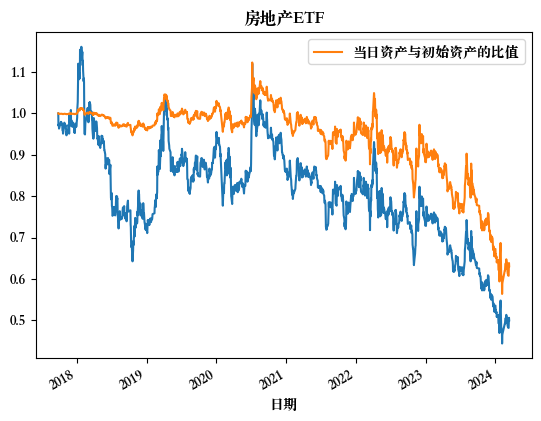

开始计算中概互联网ETF
第 1 / 30 期（2017-01-18 00:00:00）: 966658.03 + 33314.97 = 999973.0
第 2 / 30 期（2017-04-18 00:00:00）: 933396.6 + 70692.79 = 1004089.39
第 3 / 30 期（2017-07-17 00:00:00）: 900108.95 + 117875.89 = 1017984.84
第 4 / 30 期（2017-10-16 00:00:00）: 866835.81 + 166531.86 = 1033367.67
第 5 / 30 期（2018-01-15 00:00:00）: 833636.6 + 211433.35 = 1045069.95
第 6 / 30 期（2018-04-13 00:00:00）: 800378.37 + 221303.3 = 1021681.6699999999
第 7 / 30 期（2018-07-12 00:00:00）: 767027.2 + 264202.34 = 1031229.54
第 8 / 30 期（2018-10-10 00:00:00）: 733673.73 + 246809.03 = 980482.76
第 9 / 30 期（2019-01-08 00:00:00）: 700412.7 + 253073.93 = 953486.6299999999
第 10 / 30 期（2019-04-08 00:00:00）: 667071.53 + 340719.02 = 1007790.55
第 11 / 30 期（2019-07-08 00:00:00）: 633766.08 + 352360.42 = 986126.5
第 12 / 30 期（2019-10-08 00:00:00）: 600440.22 + 380765.4 = 981205.62
第 13 / 30 期（2020-01-03 00:00:00）: 567185.99 + 501376.31 = 1068562.3
第 14 / 30 期（2020-04-02 00:00:00）: 533915.35 + 499483.13 = 1033398.48
第 15 / 30 期（2020-07-01 00:00:0

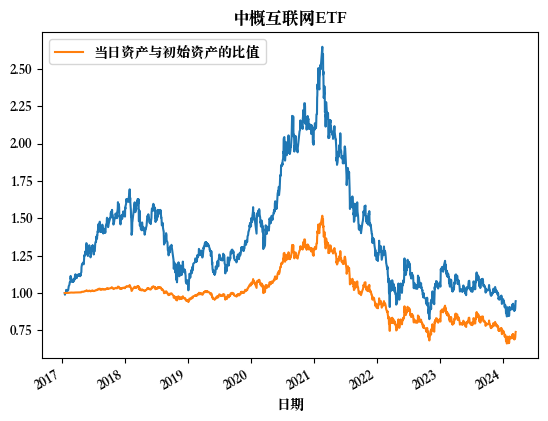

开始计算沪深300ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967992.84 + 31981.24 = 999974.08
第 2 / 31 期（2016-11-30 00:00:00）: 935782.6 + 66261.5 = 1002044.1
第 3 / 31 期（2017-02-28 00:00:00）: 903579.97 + 96164.03 = 999744.0
第 4 / 31 期（2017-05-31 00:00:00）: 871575.81 + 129772.17 = 1001347.9800000001
第 5 / 31 期（2017-08-28 00:00:00）: 839299.95 + 174720.04 = 1014019.99
第 6 / 31 期（2017-11-27 00:00:00）: 807008.88 + 218878.24 = 1025887.12
第 7 / 31 期（2018-02-23 00:00:00）: 775013.92 + 248840.15 = 1023854.0700000001
第 8 / 31 期（2018-05-24 00:00:00）: 742881.32 + 269201.39 = 1012082.71
第 9 / 31 期（2018-08-22 00:00:00）: 710722.7 + 270936.05 = 981658.75
第 10 / 31 期（2018-11-20 00:00:00）: 678723.94 + 298532.97 = 977256.9099999999
第 11 / 31 期（2019-02-18 00:00:00）: 646608.74 + 338596.34 = 985205.0800000001
第 12 / 31 期（2019-05-20 00:00:00）: 614512.44 + 395533.74 = 1010046.1799999999
第 13 / 31 期（2019-08-19 00:00:00）: 582325.22 + 444071.46 = 1026396.6799999999
第 14 / 31 期（2019-11-15 00:00:00）: 550138.0 + 493995.49 = 1044133

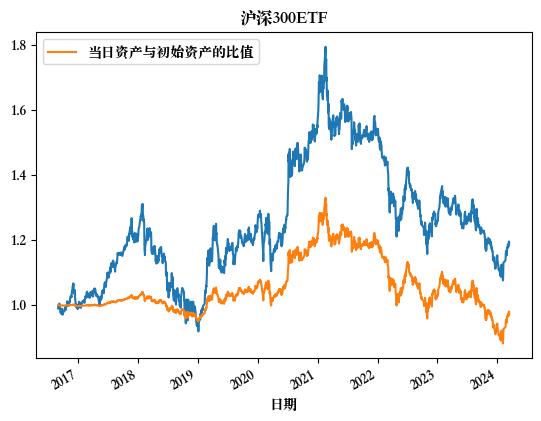

开始计算上证50ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967800.27 + 32173.66 = 999973.93
第 2 / 31 期（2016-11-30 00:00:00）: 935783.61 + 66763.28 = 1002546.89
第 3 / 31 期（2017-02-28 00:00:00）: 903522.36 + 97247.17 = 1000769.53
第 4 / 31 期（2017-05-31 00:00:00）: 871419.16 + 133092.24 = 1004511.4
第 5 / 31 期（2017-08-28 00:00:00）: 839384.3 + 179001.4 = 1018385.7000000001
第 6 / 31 期（2017-11-27 00:00:00）: 807100.14 + 223810.82 = 1030910.96
第 7 / 31 期（2018-02-23 00:00:00）: 775100.78 + 256120.62 = 1031221.4
第 8 / 31 期（2018-05-24 00:00:00）: 742843.03 + 268289.99 = 1011133.02
第 9 / 31 期（2018-08-22 00:00:00）: 710563.07 + 286216.38 = 996779.45
第 10 / 31 期（2018-11-20 00:00:00）: 678419.86 + 319711.97 = 998131.83
第 11 / 31 期（2019-02-18 00:00:00）: 646266.84 + 357858.86 = 1004125.7
第 12 / 31 期（2019-05-20 00:00:00）: 614002.18 + 412463.56 = 1026465.74
第 13 / 31 期（2019-08-19 00:00:00）: 581964.41 + 467172.63 = 1049137.04
第 14 / 31 期（2019-11-15 00:00:00）: 549709.06 + 517747.08 = 1067456.1400000001
第 15 / 31 期（2020-02-13 00:

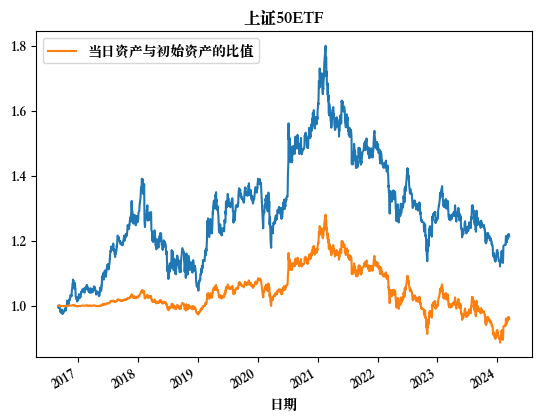

开始计算中证500ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967754.25 + 32219.64 = 999973.89
第 2 / 31 期（2016-11-30 00:00:00）: 935538.01 + 65349.89 = 1000887.9
第 3 / 31 期（2017-02-28 00:00:00）: 903309.37 + 95666.04 = 998975.41
第 4 / 31 期（2017-05-31 00:00:00）: 871144.15 + 120391.61 = 991535.76
第 5 / 31 期（2017-08-28 00:00:00）: 839018.15 + 162189.43 = 1001207.5800000001
第 6 / 31 期（2017-11-27 00:00:00）: 806815.92 + 191947.42 = 998763.3400000001
第 7 / 31 期（2018-02-23 00:00:00）: 774625.69 + 211660.94 = 986286.6299999999
第 8 / 31 期（2018-05-24 00:00:00）: 742431.66 + 249701.58 = 992133.24
第 9 / 31 期（2018-08-22 00:00:00）: 710162.8 + 236301.45 = 946464.25
第 10 / 31 期（2018-11-20 00:00:00）: 677973.27 + 256755.54 = 934728.81
第 11 / 31 期（2019-02-18 00:00:00）: 645800.15 + 284440.54 = 930240.69
第 12 / 31 期（2019-05-20 00:00:00）: 613545.7 + 342241.27 = 955786.97
第 13 / 31 期（2019-08-19 00:00:00）: 581299.85 + 365204.99 = 946504.84
第 14 / 31 期（2019-11-15 00:00:00）: 549063.11 + 409090.01 = 958153.12
第 15 / 31 期（2020-02-13 0

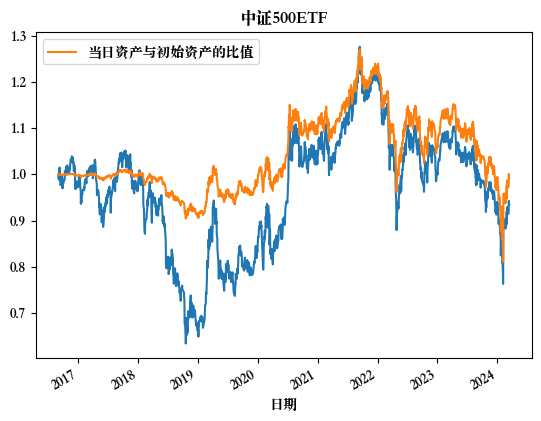

开始计算创业板ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967873.1 + 32100.89 = 999973.99
第 2 / 31 期（2016-11-30 00:00:00）: 935600.04 + 63873.72 = 999473.76
第 3 / 31 期（2017-02-28 00:00:00）: 903450.03 + 89171.74 = 992621.77
第 4 / 31 期（2017-05-31 00:00:00）: 871292.51 + 115123.48 = 986415.99
第 5 / 31 期（2017-08-28 00:00:00）: 839120.89 + 147938.76 = 987059.65
第 6 / 31 期（2017-11-27 00:00:00）: 806858.33 + 175212.53 = 982070.86
第 7 / 31 期（2018-02-23 00:00:00）: 774695.71 + 197387.88 = 972083.59
第 8 / 31 期（2018-05-24 00:00:00）: 742419.45 + 250679.36 = 993098.8099999999
第 9 / 31 期（2018-08-22 00:00:00）: 710136.69 + 231333.98 = 941470.6699999999
第 10 / 31 期（2018-11-20 00:00:00）: 677882.44 + 252037.17 = 929919.61
第 11 / 31 期（2019-02-18 00:00:00）: 645644.19 + 283100.21 = 928744.3999999999
第 12 / 31 期（2019-05-20 00:00:00）: 613438.36 + 337322.89 = 950761.25
第 13 / 31 期（2019-08-19 00:00:00）: 581185.31 + 397261.9 = 978447.2100000001
第 14 / 31 期（2019-11-15 00:00:00）: 548978.27 + 454921.7 = 1003899.97
第 15 / 31 期（2020-02

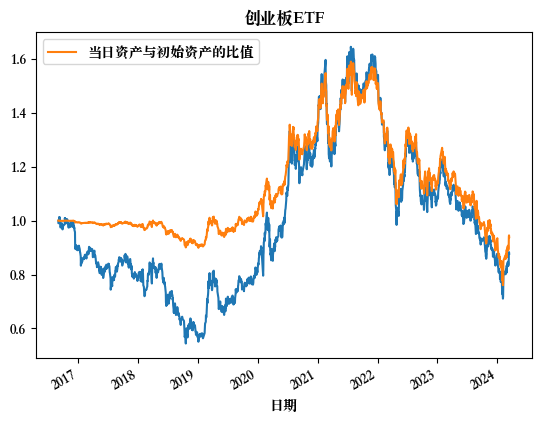

开始计算中小100ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967744.65 + 32229.24 = 999973.89
第 2 / 31 期（2016-11-30 00:00:00）: 935712.59 + 64012.26 = 999724.85
第 3 / 31 期（2017-02-28 00:00:00）: 903438.73 + 93452.6 = 996891.33
第 4 / 31 期（2017-05-31 00:00:00）: 871291.12 + 124268.34 = 995559.46
第 5 / 31 期（2017-08-28 00:00:00）: 839194.42 + 170082.83 = 1009277.25
第 6 / 31 期（2017-11-27 00:00:00）: 807260.49 + 213361.22 = 1020621.71
第 7 / 31 期（2018-02-23 00:00:00）: 774985.73 + 233349.62 = 1008335.35
第 8 / 31 期（2018-05-24 00:00:00）: 742774.29 + 267723.63 = 1010497.92
第 9 / 31 期（2018-08-22 00:00:00）: 710508.93 + 248744.9 = 959253.8300000001
第 10 / 31 期（2018-11-20 00:00:00）: 678324.71 + 257533.31 = 935858.02
第 11 / 31 期（2019-02-18 00:00:00）: 646086.66 + 294548.19 = 940634.8500000001
第 12 / 31 期（2019-05-20 00:00:00）: 613926.44 + 336281.33 = 950207.77
第 13 / 31 期（2019-08-19 00:00:00）: 581879.16 + 382493.26 = 964372.42
第 14 / 31 期（2019-11-15 00:00:00）: 549647.92 + 447364.55 = 997012.47
第 15 / 31 期（2020-02-13 00:00:

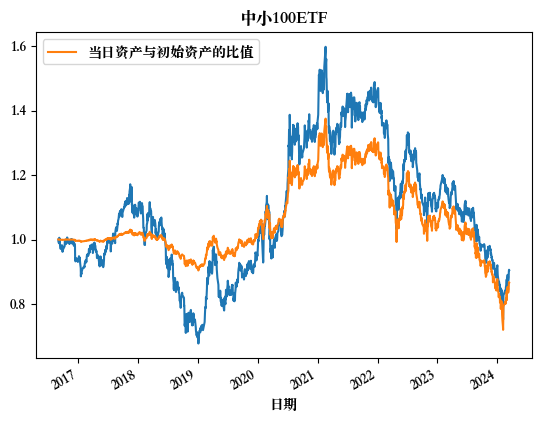

开始计算医药ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967841.88 + 32132.07 = 999973.95
第 2 / 31 期（2016-11-30 00:00:00）: 935643.65 + 65274.92 = 1000918.5700000001
第 3 / 31 期（2017-02-28 00:00:00）: 903445.42 + 97447.08 = 1000892.5
第 4 / 31 期（2017-05-31 00:00:00）: 871309.82 + 138129.08 = 1009438.8999999999
第 5 / 31 期（2017-08-28 00:00:00）: 839089.58 + 171946.03 = 1011035.61
第 6 / 31 期（2017-11-27 00:00:00）: 806941.37 + 225678.92 = 1032620.29
第 7 / 31 期（2018-02-23 00:00:00）: 774798.46 + 255467.81 = 1030266.27
第 8 / 31 期（2018-05-24 00:00:00）: 742569.82 + 353612.68 = 1096182.5
第 9 / 31 期（2018-08-22 00:00:00）: 710276.55 + 325048.77 = 1035325.3200000001
第 10 / 31 期（2018-11-20 00:00:00）: 678128.34 + 327708.03 = 1005836.37
第 11 / 31 期（2019-02-18 00:00:00）: 645892.6 + 338706.8 = 984599.3999999999
第 12 / 31 期（2019-05-20 00:00:00）: 613639.95 + 408202.8 = 1021842.75
第 13 / 31 期（2019-08-19 00:00:00）: 581429.31 + 458965.16 = 1040394.47
第 14 / 31 期（2019-11-15 00:00:00）: 549191.06 + 569997.8 = 1119188.86
第 15 / 31 期（

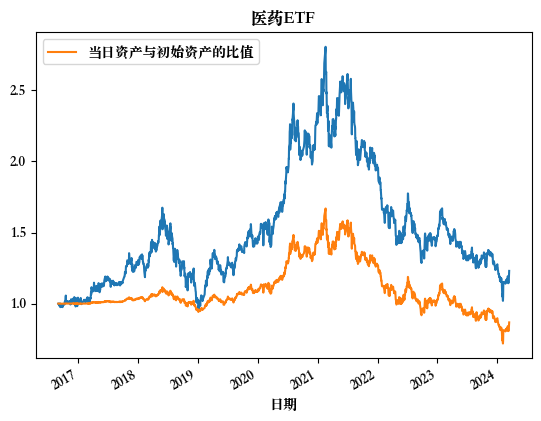

开始计算证券ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967763.76 + 32210.14 = 999973.9
第 2 / 31 期（2016-11-30 00:00:00）: 935602.74 + 66654.53 = 1002257.27
第 3 / 31 期（2017-02-28 00:00:00）: 903429.92 + 93813.95 = 997243.87
第 4 / 31 期（2017-05-31 00:00:00）: 871177.67 + 120773.64 = 991951.31
第 5 / 31 期（2017-08-28 00:00:00）: 838911.81 + 162266.2 = 1001178.01
第 6 / 31 期（2017-11-27 00:00:00）: 806690.57 + 190055.25 = 996745.82
第 7 / 31 期（2018-02-23 00:00:00）: 774494.34 + 195701.81 = 970196.1499999999
第 8 / 31 期（2018-05-24 00:00:00）: 742274.1 + 224831.28 = 967105.38
第 9 / 31 期（2018-08-22 00:00:00）: 710050.66 + 215894.72 = 925945.38
第 10 / 31 期（2018-11-20 00:00:00）: 677824.42 + 280223.85 = 958048.27
第 11 / 31 期（2019-02-18 00:00:00）: 645564.07 + 313475.85 = 959039.9199999999
第 12 / 31 期（2019-05-20 00:00:00）: 613307.22 + 365369.73 = 978676.95
第 13 / 31 期（2019-08-19 00:00:00）: 581080.98 + 409596.8 = 990677.78
第 14 / 31 期（2019-11-15 00:00:00）: 548850.74 + 439550.42 = 988401.1599999999
第 15 / 31 期（2020-02-13 00:00

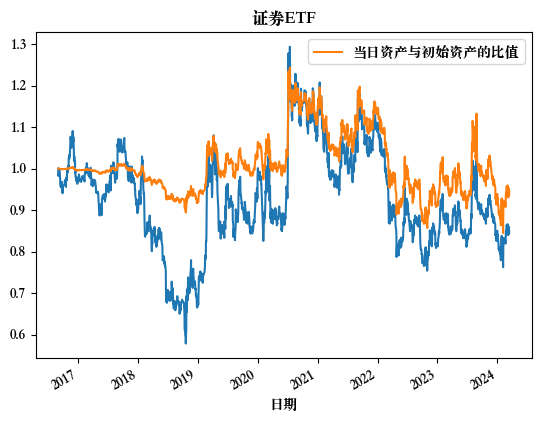

开始计算环保ETF
第 1 / 29 期（2017-02-28 00:00:00）: 965581.73 + 34390.41 = 999972.14
第 2 / 29 期（2017-05-31 00:00:00）: 931153.86 + 67354.62 = 998508.48
第 3 / 29 期（2017-08-28 00:00:00）: 896709.77 + 104146.4 = 1000856.17
第 4 / 29 期（2017-11-27 00:00:00）: 862220.36 + 140590.62 = 1002810.98
第 5 / 29 期（2018-02-23 00:00:00）: 827776.07 + 157726.95 = 985503.02
第 6 / 29 期（2018-05-24 00:00:00）: 793283.76 + 196611.92 = 989895.68
第 7 / 29 期（2018-08-22 00:00:00）: 758814.67 + 190958.85 = 949773.52
第 8 / 29 期（2018-11-20 00:00:00）: 724321.96 + 219668.7 = 943990.6599999999
第 9 / 29 期（2019-02-18 00:00:00）: 689877.97 + 253774.53 = 943652.5
第 10 / 29 期（2019-05-20 00:00:00）: 655402.48 + 294324.19 = 949726.6699999999
第 11 / 29 期（2019-08-19 00:00:00）: 620951.49 + 324275.51 = 945227.0
第 12 / 29 期（2019-11-15 00:00:00）: 586452.18 + 359201.68 = 945653.8600000001
第 13 / 29 期（2020-02-13 00:00:00）: 551963.07 + 459566.8 = 1011529.8699999999
第 14 / 29 期（2020-05-13 00:00:00）: 517470.66 + 463574.78 = 981045.44
第 15 / 29 期（2020-08

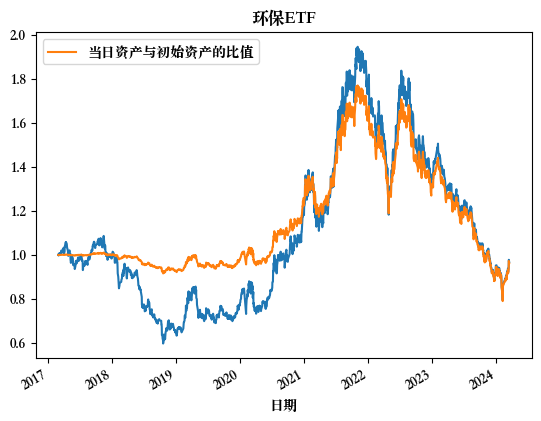

开始计算恒生ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967832.58 + 32141.37 = 999973.95
第 2 / 31 期（2016-11-30 00:00:00）: 935669.66 + 65149.08 = 1000818.74
第 3 / 31 期（2017-02-28 00:00:00）: 903480.63 + 100280.46 = 1003761.09
第 4 / 31 期（2017-05-31 00:00:00）: 871248.09 + 140076.95 = 1011325.04
第 5 / 31 期（2017-08-28 00:00:00）: 839008.64 + 180752.64 = 1019761.28
第 6 / 31 期（2017-11-27 00:00:00）: 806735.88 + 226688.98 = 1033424.86
第 7 / 31 期（2018-02-23 00:00:00）: 774603.68 + 258936.41 = 1033540.0900000001
第 8 / 31 期（2018-05-24 00:00:00）: 742395.64 + 287893.76 = 1030289.4
第 9 / 31 期（2018-08-22 00:00:00）: 710218.32 + 311513.49 = 1021731.8099999999
第 10 / 31 期（2018-11-20 00:00:00）: 677985.68 + 331372.85 = 1009358.53
第 11 / 31 期（2019-02-18 00:00:00）: 645733.43 + 379741.64 = 1025475.0700000001
第 12 / 31 期（2019-05-20 00:00:00）: 613556.71 + 416547.21 = 1030103.9199999999
第 13 / 31 期（2019-08-19 00:00:00）: 581273.25 + 432609.9 = 1013883.15
第 14 / 31 期（2019-11-15 00:00:00）: 549075.02 + 473962.11 = 1023037.13
第 15 /

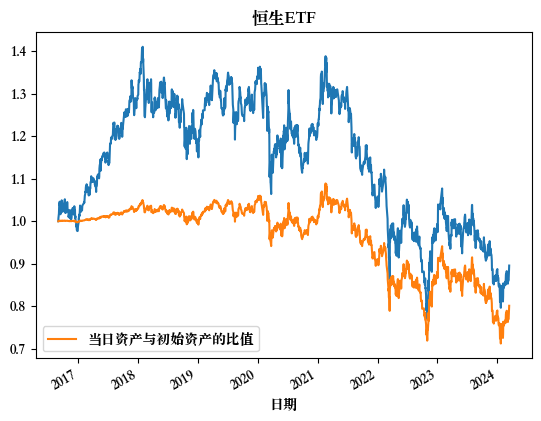

开始计算H股ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967794.77 + 32179.16 = 999973.93
第 2 / 31 期（2016-11-30 00:00:00）: 935530.71 + 66778.57 = 1002309.28
第 3 / 31 期（2017-02-28 00:00:00）: 903341.38 + 101376.78 = 1004718.16
第 4 / 31 期（2017-05-31 00:00:00）: 871104.64 + 135192.34 = 1006296.98
第 5 / 31 期（2017-08-28 00:00:00）: 838892.6 + 176039.97 = 1014932.57
第 6 / 31 期（2017-11-27 00:00:00）: 806727.28 + 215627.64 = 1022354.92
第 7 / 31 期（2018-02-23 00:00:00）: 774513.64 + 252528.37 = 1027042.01
第 8 / 31 期（2018-05-24 00:00:00）: 742303.0 + 272944.98 = 1015247.98
第 9 / 31 期（2018-08-22 00:00:00）: 710078.16 + 297051.62 = 1007129.78
第 10 / 31 期（2018-11-20 00:00:00）: 677865.72 + 328011.49 = 1005877.21
第 11 / 31 期（2019-02-18 00:00:00）: 645619.97 + 368118.64 = 1013738.61
第 12 / 31 期（2019-05-20 00:00:00）: 613346.91 + 396490.63 = 1009837.54
第 13 / 31 期（2019-08-19 00:00:00）: 581081.05 + 424187.92 = 1005268.97
第 14 / 31 期（2019-11-15 00:00:00）: 548823.3 + 469412.07 = 1018235.3700000001
第 15 / 31 期（2020-02-13 00:00:00

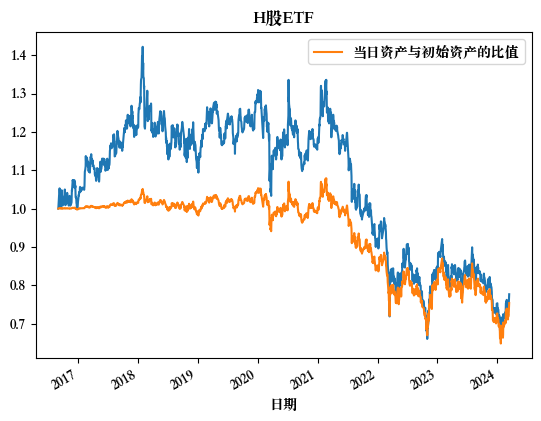

开始计算标普500ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967813.28 + 32160.67 = 999973.9500000001
第 2 / 31 期（2016-11-30 00:00:00）: 935578.64 + 69839.95 = 1005418.59
第 3 / 31 期（2017-02-28 00:00:00）: 903446.04 + 96169.03 = 999615.0700000001
第 4 / 31 期（2017-05-31 00:00:00）: 871277.02 + 130735.36 = 1002012.38
第 5 / 31 期（2017-08-28 00:00:00）: 839014.77 + 159081.56 = 998096.3300000001
第 6 / 31 期（2017-11-27 00:00:00）: 806786.43 + 200510.54 = 1007296.9700000001
第 7 / 31 期（2018-02-23 00:00:00）: 774603.41 + 231404.05 = 1006007.46
第 8 / 31 期（2018-05-24 00:00:00）: 742472.61 + 268938.11 = 1011410.72
第 9 / 31 期（2018-08-22 00:00:00）: 710281.78 + 335095.05 = 1045376.8300000001
第 10 / 31 期（2018-11-20 00:00:00）: 678049.44 + 349790.82 = 1027840.26
第 11 / 31 期（2019-02-18 00:00:00）: 645921.24 + 384532.18 = 1030453.4199999999
第 12 / 31 期（2019-05-20 00:00:00）: 613638.98 + 440710.81 = 1054349.79
第 13 / 31 期（2019-08-19 00:00:00）: 581499.87 + 486446.74 = 1067946.6099999999
第 14 / 31 期（2019-11-15 00:00:00）: 549274.23 + 550

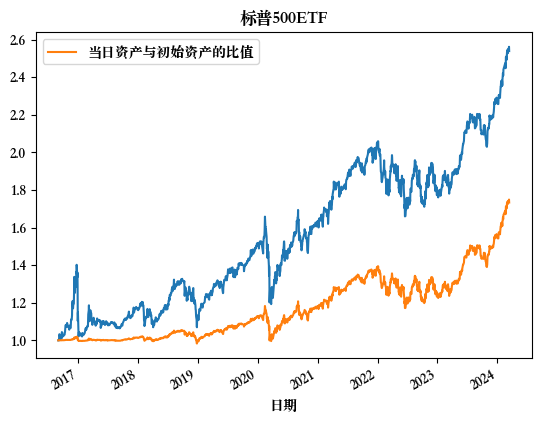

开始计算纳指ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967820.78 + 32153.17 = 999973.9500000001
第 2 / 31 期（2016-11-30 00:00:00）: 935642.26 + 66280.78 = 1001923.04
第 3 / 31 期（2017-02-28 00:00:00）: 903422.02 + 104191.98 = 1007614.0
第 4 / 31 期（2017-05-31 00:00:00）: 871157.36 + 144757.33 = 1015914.69
第 5 / 31 期（2017-08-28 00:00:00）: 838975.84 + 172861.24 = 1011837.08
第 6 / 31 期（2017-11-27 00:00:00）: 806697.58 + 218695.92 = 1025393.5
第 7 / 31 期（2018-02-23 00:00:00）: 774610.5 + 254022.63 = 1028633.13
第 8 / 31 期（2018-05-24 00:00:00）: 742361.45 + 296777.93 = 1039139.3799999999
第 9 / 31 期（2018-08-22 00:00:00）: 710141.21 + 367593.86 = 1077735.0699999998
第 10 / 31 期（2018-11-20 00:00:00）: 677915.37 + 366932.95 = 1044848.3200000001
第 11 / 31 期（2019-02-18 00:00:00）: 645663.12 + 410759.3 = 1056422.42
第 12 / 31 期（2019-05-20 00:00:00）: 613568.53 + 478603.71 = 1092172.24
第 13 / 31 期（2019-08-19 00:00:00）: 581471.33 + 527362.13 = 1108833.46
第 14 / 31 期（2019-11-15 00:00:00）: 549348.43 + 599341.97 = 1148690.4
第 15 / 31

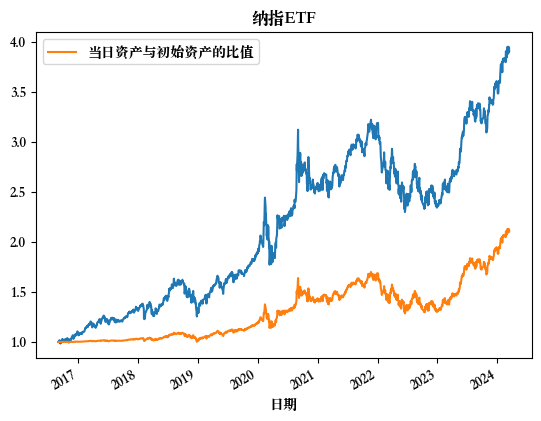

开始计算军工ETF
第 1 / 31 期（2016-09-01 00:00:00）: 967794.77 + 32179.16 = 999973.93
第 2 / 31 期（2016-11-30 00:00:00）: 935569.13 + 64095.33 = 999664.46
第 3 / 31 期（2017-02-28 00:00:00）: 903358.49 + 97482.07 = 1000840.56
第 4 / 31 期（2017-05-31 00:00:00）: 871112.74 + 112982.39 = 984095.13
第 5 / 31 期（2017-08-28 00:00:00）: 838898.2 + 150720.86 = 989619.0599999999
第 6 / 31 期（2017-11-27 00:00:00）: 806696.07 + 177183.97 = 983880.0399999999
第 7 / 31 期（2018-02-23 00:00:00）: 774417.31 + 183156.71 = 957574.02
第 8 / 31 期（2018-05-24 00:00:00）: 742182.67 + 237045.02 = 979227.6900000001
第 9 / 31 期（2018-08-22 00:00:00）: 709965.43 + 227710.04 = 937675.4700000001
第 10 / 31 期（2018-11-20 00:00:00）: 677697.17 + 257937.04 = 935634.2100000001
第 11 / 31 期（2019-02-18 00:00:00）: 645447.32 + 294382.96 = 939830.28
第 12 / 31 期（2019-05-20 00:00:00）: 613228.98 + 345539.86 = 958768.84
第 13 / 31 期（2019-08-19 00:00:00）: 581009.74 + 388189.51 = 969199.25
第 14 / 31 期（2019-11-15 00:00:00）: 548724.08 + 406455.55 = 955179.6299999999
第 

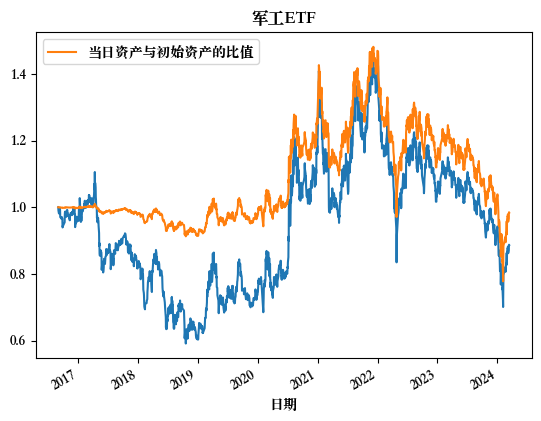

In [85]:
for i in range(len(stockNameCodes)):
    calc(stockNameCodes[i])
    plt.show()